In [ ]:
import pandas as pd

from helpers import convert_epoch_column_to_datetime, draw_map

In [ ]:
# weather = pd.read_csv("data/wind/weather_ege.csv")
# weather.drop(columns=["latlon", "rn"]).to_parquet("data/wind/weather_ege.parquet")
weather = pd.read_parquet("data/wind/weather_large.parquet")

In [ ]:
### bring datetime column from epoch
# weather_ = weather[(weather["lat"] == 38) & (weather["lon"] == 26)].sort_values("forecast_epoch").reset_index(drop=True)
# weather_["forecast_dt"] = convert_epoch_column_to_datetime(weather_["forecast_epoch"], turkey_time=True)
# weather_.head()

In [ ]:
draw_map(weather)

In [ ]:
# farms = pd.read_csv("data/wind/ege_farms.csv")
# farms.rename(columns={"long": "lon"}).to_csv("data/wind/ege_farms.csv", index=False)
farms = pd.read_csv("data/wind/ege_farms.csv")
draw_map(farms)

In [ ]:
farms[(farms["lat"] > 38) & (farms["lon"] > 29)]
farms[farms["province"] == "Usak"] # this may be dropped
farms[farms["province"] == "Bursa"] # location on harmanlık or karacabey is probably wrong

In [ ]:
# prod = pd.read_csv("data/wind/production_large.csv", index_col=0)
# prod.drop(columns=["name"]).to_parquet("data/wind/production_large.parquet")
prod = pd.read_parquet("data/wind/production_large.parquet")

In [ ]:
prod["forecast_dt"] = convert_epoch_column_to_datetime(prod["epoch"], turkey_time=True)
prod = prod[prod.forecast_dt.dt.year >= 2018].reset_index(drop=True)

In [ ]:
prod.rt_plant_id.value_counts().hist()

In [ ]:
prod["prev_epoch"] = prod.groupby("rt_plant_id").epoch.shift(1).fillna(method="bfill").astype(int)
prod["diff"] = prod["epoch"] - prod["prev_epoch"]
prod[(prod["diff"]!= 3600) & (prod["diff"]!= 0)].shape

In [ ]:
a = prod[(prod["diff"]!= 3600) & (prod["diff"]!= 0)]
a["dt"] = convert_epoch_column_to_datetime(a["epoch"], turkey_time=True)
a["diff"] = a["diff"] / 3600
missing_prod_plants = a.rt_plant_id.unique()
a.head()

In [ ]:
a.groupby("rt_plant_id")["diff"].sum().sort_values(ascending=False)
# prod[(prod["diff"]!= 3600) & (prod["diff"]!= 0)].rt_plant_id.value_counts()

In [ ]:
farms.query("rt_plant_id == 2326")

In [ ]:
# prod["dt"] = convert_epoch_column_to_datetime(prod["epoch"])
# prod.drop(columns=["dt"], inplace=True)

In [ ]:
prod

In [ ]:
print(prod.shape)
prod = prod[~prod["rt_plant_id"].isin(missing_prod_plants)]
print(prod.shape)

In [ ]:
prod

In [ ]:
prod[prod["rt_plant_id"] == 1509].set_index("forecast_dt").production.plot(figsize=(20,15))

In [ ]:
prod[(prod["forecast_dt"].dt.year == 2020) & (prod["rt_plant_id"] == 1509)].groupby(prod.forecast_dt.dt.date).production.sum().plot(figsize=(20,15))

In [ ]:
farms[farms["rt_plant_id"] == 968]

In [ ]:
prod = prod.drop(columns=["prev_epoch", "diff"])
prod

In [ ]:
weather

In [ ]:
farms = farms[farms["rt_plant_id"].isin(prod["rt_plant_id"].unique())]
farms

In [ ]:
import numpy as np
import itertools

In [ ]:
longitudes = weather.lon.unique()
latitudes = weather.lat.unique()

def generate_bbox_weather(lat_, lon_):
    lon_bounds = np.max(longitudes[longitudes < lon_]), np.min(longitudes[longitudes > lon_])
    lat_bounds = np.max(latitudes[latitudes < lat_]), np.min(latitudes[latitudes > lat_])
    # bbox = list(itertools.product(lon_bounds, lat_bounds))
    temp_weather = weather[(weather["lat"].isin(lat_bounds)) & (weather["lon"].isin(lon_bounds))].sort_values(["forecast_epoch", "lon", "lat"]).reset_index(drop=True)
    temp_weather = temp_weather.pivot_table(index="forecast_epoch", columns=["lon", "lat"], values=["UGRD_80.m.above.ground", "VGRD_80.m.above.ground"])
    # temp_weather.columns = temp_weather.columns.to_flat_index()
    temp_weather.columns = temp_weather.columns.get_level_values(0) + [".SW", ".NW", ".NE", ".SE"] * 2
    return temp_weather

In [ ]:
df_list = []
for _, (lat, lon, plant) in farms[["lat", "lon", "rt_plant_id"]].iterrows():
    df_ = generate_bbox_weather(lat, lon)
    df_["rt_plant_id"] = plant
    df_list.append(df_)

In [ ]:
weather_prepared = pd.concat(df_list).reset_index()
weather_prepared["rt_plant_id"] = weather_prepared["rt_plant_id"].astype(int)
weather_prepared.rename(columns={"forecast_epoch": "epoch"}, inplace=True)

In [ ]:
prod

In [ ]:
prod = pd.merge(prod, weather_prepared, on=["epoch", "rt_plant_id"])
prod

In [ ]:
prod[prod["epoch"] == 1514754000]

# Enriched

In [31]:
# prod.to_parquet("data/wind/enriched.parquet")

In [32]:
import pandas as pd

In [33]:
prod = pd.read_parquet("data/wind/enriched.parquet")

In [53]:
prod.rt_plant_id.unique()

array([1503, 1485, 1499, 1490, 1524, 1194, 1516, 1506, 1507, 1460, 1472,
       1487, 1492, 1512, 1501,  969, 1519, 1494, 1484, 1517, 2062, 1527,
       1528, 1489, 1525, 1509, 1459, 1491, 1514, 1508, 1504, 1523, 2420,
       1493, 1470, 1488, 1709, 1511, 1502, 1498, 1518,  757, 2538,  968,
       1513, 1655, 1505, 1537, 1578, 1737, 1712, 2098, 1761, 1741, 1759,
       1787, 1883, 1843, 1899, 1929, 1900, 1878, 1944, 1939, 1945, 1928,
       1943, 1977, 1959, 2031, 2040, 2050, 2063, 2058, 2070, 2083, 2089,
       2123, 2116, 2104, 2112, 2113, 2114, 2125, 2140, 2180, 2166, 2184,
       2225, 2224, 2235, 2073, 2288,  749, 2326, 2397,  672, 1781, 2291,
       2323, 2374])

1472


<AxesSubplot:xlabel='forecast_dt'>

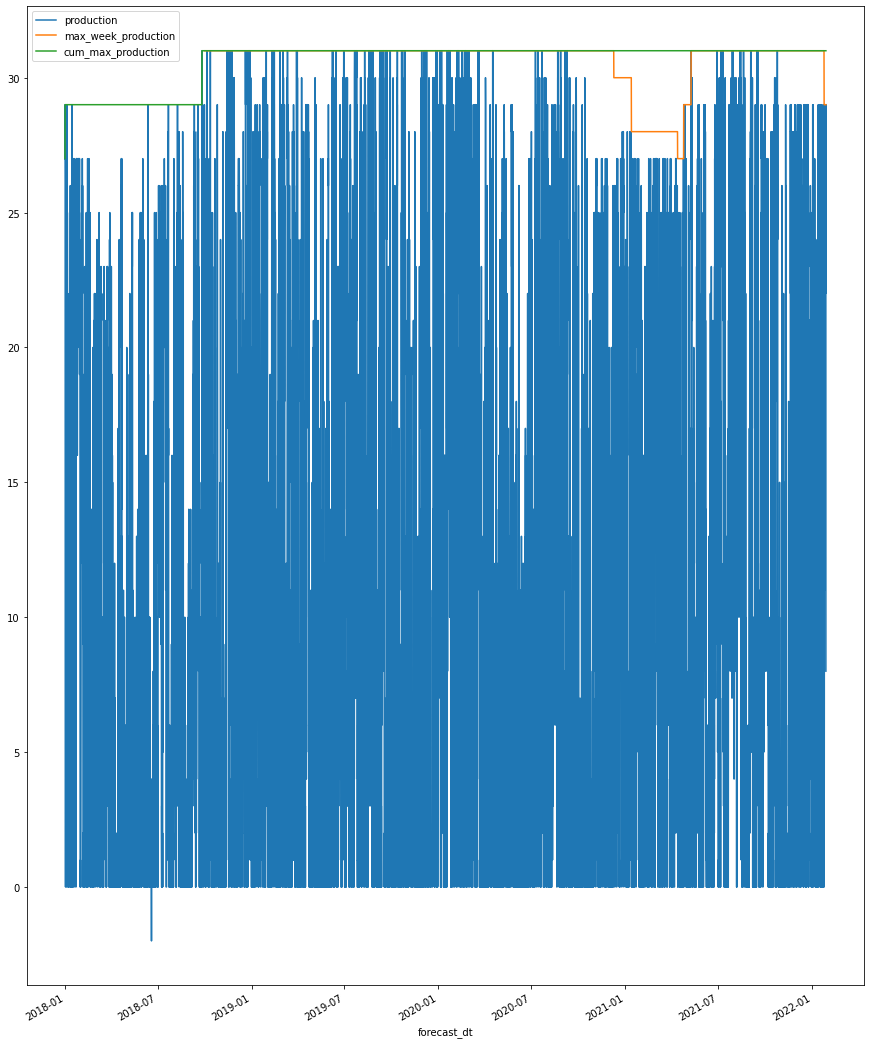

In [59]:
PLANT_ID = prod.rt_plant_id.unique()[10]
print(PLANT_ID)
a = prod.loc[prod["rt_plant_id"] == PLANT_ID, ["forecast_dt", "production"]]
a["max_week_production"] = a["production"].rolling(13*7*24).max()
a["cum_max_production"] = a["production"].cummax()
a.set_index("forecast_dt").plot(figsize=(15,20))

In [ ]:
prod

In [8]:
prod["dayofweek"] = prod.forecast_dt.dt.dayofweek
prod["hour"] = prod.forecast_dt.dt.hour
prod.sort_values(["rt_plant_id", "forecast_dt"], inplace=True)

In [9]:
for i in range(7*24, 14*24):
    if i % 24 in [0, 1, 2]:
        prod[f"production_shift_{i}"] = prod.groupby("rt_plant_id")["production"].shift(i)

In [10]:
prod = prod.dropna()
# prod

In [11]:
import lightgbm as lgb

In [12]:
df_train = prod[prod["forecast_dt"].dt.year < 2022].reset_index(drop=True)
df_test = prod[prod["forecast_dt"].dt.year == 2022].reset_index(drop=True)
df_train.drop(columns=["forecast_dt", "epoch"], inplace=True)
df_test.drop(columns=["forecast_dt", "epoch"], inplace=True)

In [13]:
y_train = df_train["production"]
y_test = df_test["production"]
X_train = df_train.drop("production", axis=1)
X_test = df_test.drop("production", axis=1)


In [14]:
for col in ["rt_plant_id", "hour", "dayofweek"]:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

In [15]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    "num_boost_round": 1000,
    'metric': {'l2', 'l1'},
    'num_leaves': 51,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    "categorical_feature": ["rt_plant_id", "hour", "dayofweek"]
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=20)]
                )


Starting training...
[LightGBM] [Warning] categorical_feature is set=rt_plant_id,hour,dayofweek, categorical_column=0,9,10 will be ignored. Current value: categorical_feature=rt_plant_id,hour,dayofweek
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7529
[LightGBM] [Info] Number of data points in the train set: 2853503, number of used features: 32
[LightGBM] [Info] Start training from score 14.274744
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[375]	valid_0's l1: 6.47564	valid_0's l2: 134.831


In [16]:
# print('Saving model...')
# save model to file
# gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
from sklearn.metrics import mean_squared_error
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

Starting predicting...
The RMSE of prediction is: 11.611679359586956


In [17]:
y_pred

array([3.15002289, 3.27386637, 3.38273511, ..., 3.13731314, 3.17447643,
       2.80984077])

In [ ]:
# df_test

In [18]:
feature_importances = gbm.feature_importance()
feature_names = gbm.feature_name()
pd.DataFrame([feature_importances, feature_names]).T.sort_values(0, ascending=False)

,0,1
0,5414,rt_plant_id
6,1528,VGRD_80.m.above.ground.NW
5,1494,VGRD_80.m.above.ground.SW
8,1357,VGRD_80.m.above.ground.SE
7,1125,VGRD_80.m.above.ground.NE
3,970,UGRD_80.m.above.ground.NE
10,915,hour
4,777,UGRD_80.m.above.ground.SE
2,710,UGRD_80.m.above.ground.NW
1,655,UGRD_80.m.above.ground.SW


In [30]:
prod

,epoch,production,rt_plant_id,forecast_dt,UGRD_80.m.above.ground.SW,UGRD_80.m.above.ground.NW,UGRD_80.m.above.ground.NE,UGRD_80.m.above.ground.SE,VGRD_80.m.above.ground.SW,VGRD_80.m.above.ground.NW,...,production_shift_242,production_shift_264,production_shift_265,production_shift_266,production_shift_288,production_shift_289,production_shift_290,production_shift_312,production_shift_313,production_shift_314
index,,,,,,,,,,,,,,,,,,,,,
2808749,1518145200,5.0,672,2018-02-09 06:00:00+03:00,1.152970,1.562970,1.08297,1.682970,3.850870,4.250870,...,38.0,36.0,40.0,39.0,11.0,1.0,0.0,4.0,4.0,1.0
2808750,1518156000,6.0,672,2018-02-09 09:00:00+03:00,1.393990,1.833990,1.44399,2.313990,3.158530,3.038530,...,12.0,58.0,36.0,40.0,9.0,11.0,1.0,17.0,4.0,4.0
2808751,1518166800,3.0,672,2018-02-09 12:00:00+03:00,0.586377,0.566377,1.10638,1.496380,1.734590,1.774590,...,0.0,48.0,58.0,36.0,4.0,9.0,11.0,15.0,17.0,4.0
2808752,1518177600,0.0,672,2018-02-09 15:00:00+03:00,0.911506,-0.158494,1.59151,0.961506,-0.140388,0.529612,...,1.0,12.0,48.0,58.0,0.0,4.0,9.0,6.0,15.0,17.0
2808753,1518188400,0.0,672,2018-02-09 18:00:00+03:00,-2.065970,-2.325970,-1.71597,-1.755970,-1.616040,0.703962,...,3.0,7.0,12.0,48.0,34.0,0.0,4.0,18.0,6.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249914,1643299200,20.0,2538,2022-01-27 19:00:00+03:00,-0.504146,-3.094150,-3.31415,-2.784150,-2.450970,-1.850970,...,3.0,17.0,17.0,18.0,20.0,19.0,19.0,5.0,7.0,12.0
1249915,1643302800,18.0,2538,2022-01-27 20:00:00+03:00,-0.437156,-2.807160,-3.45716,-2.677160,-1.984660,-1.864660,...,3.0,17.0,17.0,17.0,20.0,20.0,19.0,4.0,5.0,7.0
1249916,1643306400,20.0,2538,2022-01-27 21:00:00+03:00,-0.180332,-2.490330,-3.52033,-2.690330,-1.867400,-1.817400,...,4.0,14.0,17.0,17.0,20.0,20.0,20.0,5.0,4.0,5.0


In [19]:
out = prod[prod["forecast_dt"].dt.year == 2022]
out["pred"] = y_pred

In [20]:
out.groupby(["rt_plant_id"]).production.sum().sort_values()

rt_plant_id
1655      228.62
749       412.00
2104      820.73
1843     1216.08
2098     2109.01
          ...   
1507    28075.19
1484    29154.00
1518    33662.11
969     67018.47
968     72311.00
Name: production, Length: 101, dtype: float64

<AxesSubplot:xlabel='forecast_dt'>

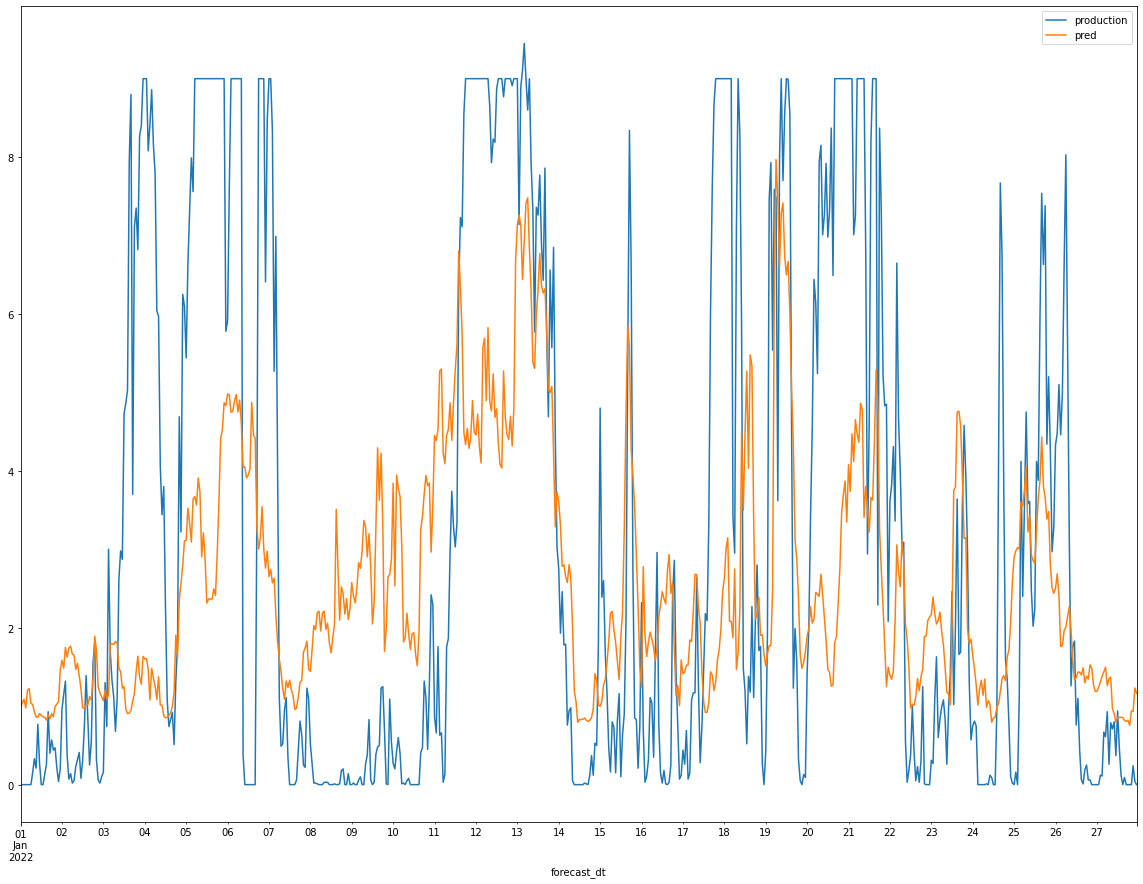

In [28]:
out_ = out[(out["rt_plant_id"] == 2098)]
out_.set_index("forecast_dt", inplace=True)
out_[["production", "pred"]].plot(figsize=(20,15))

<AxesSubplot:xlabel='forecast_dt'>

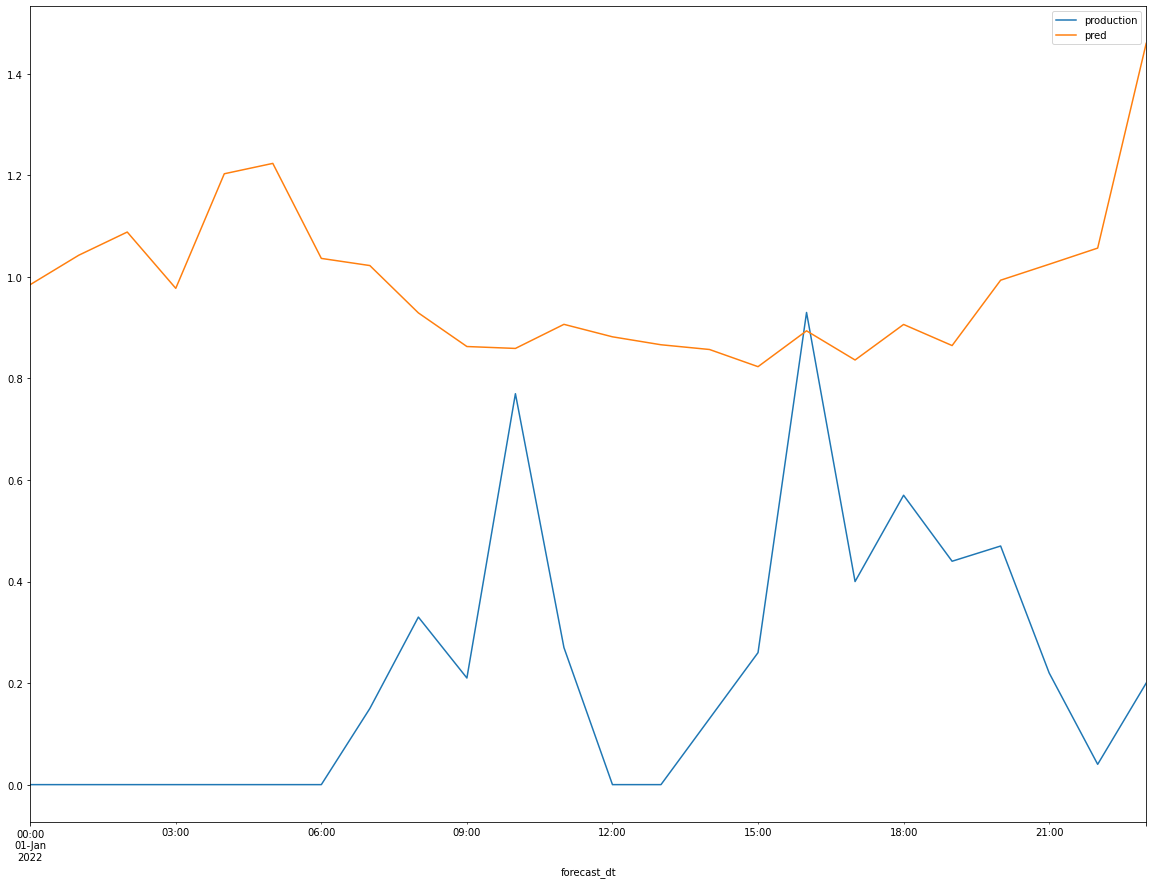

In [29]:
out_ = out[(out["rt_plant_id"] == 2098) & (out["forecast_dt"].dt.day == 1)]
out_.set_index("forecast_dt", inplace=True)
out_[["production", "pred"]].plot(figsize=(20,15))